Hevaily inspired by: https://github.com/rafaljanwojcik/Unsupervised-Sentiment-Analysis

1. To this runtime, upload the poli_data_format.csv file and the pretrained Indonesian word2vec model, *id.bin*: https://drive.google.com/file/d/0B0ZXk88koS2KQWxEemNNUHhnTWc/view (credit https://github.com/Kyubyong/wordvectors)
2. Clone cleaned Indonesian tweets and import packages:

In [1]:
!git clone https://github.com/ridife/dataset-idsa.git
#!unzip dataset-idsa/Indonesian\ Sentiment\ Tweet\ Dataset\ Unlabeled.zip

Cloning into 'dataset-idsa'...
remote: Enumerating objects: 6, done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 6
Unpacking objects: 100% (6/6), done.


In [0]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.cluster import KMeans

3. Figure out sentiment value of words in the word2vec model:

In [3]:
word_vectors = Word2Vec.load('id.bin').wv

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=100).fit(X=word_vectors.vectors)

In [0]:
model.fit(word_vectors.vectors)
y_kmeans = model.predict(word_vectors.vectors)

3.1 Graph sentiment value clusters

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


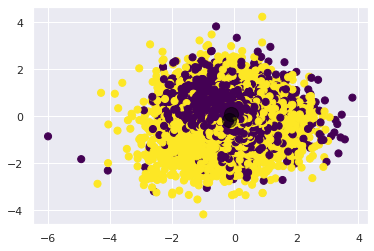

In [7]:
plt.scatter(word_vectors.vectors[:, 0], word_vectors.vectors[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

In [8]:
words = pd.DataFrame(word_vectors.vocab.keys())
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors.wv[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])
words['cluster_value'] = [-1 if i==0 else 1 for i in words.cluster] # cluster #0 seems to lean more negatively, and cluster #1 leans more positive
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
words.head(10)

,words,vectors,cluster,cluster_value,closeness_score,sentiment_coeff
0,bukunya,"[0.043560997, 0.88694453, -1.429345, 0.8567183...",0,-1,0.057561,-0.057561
1,sambung,"[-0.34190354, 0.18776654, -0.6192795, 0.195348...",1,1,0.152269,0.152269
2,anyer,"[-0.7063486, 0.553293, -0.5543846, 0.4856817, ...",0,-1,0.173120,-0.173120
3,kuripan,"[-0.4620376, 0.07623836, 0.25089735, 0.5410571...",0,-1,0.201900,-0.201900
4,persijap,"[-0.42356607, 0.37748742, 0.46421722, -0.12916...",0,-1,0.165229,-0.165229
5,murung,"[-0.23928656, 0.22169685, -0.39104718, 0.67618...",0,-1,0.106330,-0.106330
6,woods,"[0.06976533, 0.3684684, 0.343332, 1.0271071, 0...",0,-1,0.133103,-0.133103
7,spiders,"[0.022209955, 0.74383307, -0.93456376, -0.4563...",0,-1,0.065728,-0.065728
8,francesco,"[-0.6846506, 0.2922618, 0.030286498, 0.5536658...",0,-1,0.140665,-0.140665
9,woody,"[-0.16098414, 0.22051175, -0.33928707, 0.57241...",0,-1,0.148798,-0.148798


In [0]:
words[['words', 'sentiment_coeff']].to_csv('/content/sentiment_dictionary.csv', index=False)
sentiment_map = pd.read_csv('/content/sentiment_dictionary.csv')
sentiment_dict = dict(zip(sentiment_map.words.values, sentiment_map.sentiment_coeff.values))

4. Get TF-IDF weighting of words within the tweets

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from IPython.display import display

In [0]:
final_file = pd.read_csv('/content/dataset-idsa/Indonesian Sentiment Twitter Dataset Labeled.csv', sep='\t', header=0)
df2 = pd.read_csv('poli_data_format.csv', sep='\t', header=0)
final_file = pd.concat([final_file, df2])
final_file.columns = ['sen', 'tweet']
final_file = final_file[final_file.sen != 0]
final_file = final_file.reset_index(drop=True)

In [14]:
final_file # base truths of tweet sentiments

,sen,tweet
0,-1,lagu bosan apa yang aku save ni huhuhuhuhuhuhu...
1,-1,kita lanjutkan saja diam ini hingga kau dan ak...
2,1,doa rezeki tak putus inna haa zaa larizquna ma...
3,1,makasih loh ntar kita bagi hasil aku 99 9 sisa...
4,-1,aku tak faham betul jenis orang malaysia yang ...
...,...,...
5700,1,tolak propaganda opm papua aman damai indonesia
5701,1,tp niat contohnya pembagian sembako berbuat baik
5702,1,tunda mudik mudik bawa virus keluarga dikampung
5703,1,ucapan duka hentihentinya mengalir termasuk pr...


5. Edit the sentences such that every word is replaced by its TF-IDF weighting, so as to determine how much sentiment importance should be given to a word

In [0]:
file_weighting = final_file.copy()

In [16]:
tfidf = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
tfidf.fit(file_weighting.tweet)
features = pd.Series(tfidf.get_feature_names())
transformed = tfidf.transform(file_weighting.tweet)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


In [0]:
def create_tfidf_dictionary(x, transformed_file, features):
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y:dictionary[f'{y}'.lower()], x.tweet.split()))

In [18]:
%%time
replaced_tfidf_scores = file_weighting.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1) # this step takes around 3-4 minutes minutes to calculate

CPU times: user 2.71 s, sys: 48.3 ms, total: 2.75 s
Wall time: 2.71 s


In [19]:
replaced_tfidf_scores

0       [7.010216202158187, 7.251378258975075, 3.74664...
1       [2.9111210371774883, 8.550661243105335, 5.1166...
2       [6.038355619129221, 6.604751094050022, 3.28969...
3       [6.513779315844296, 6.75890177387728, 6.876684...
4       [3.6957644229639186, 6.579399326202136, 6.0939...
                              ...                        
5700    [7.3466884387794, 8.039835619339346, 8.9561263...
5701    [5.490390448413773, 6.876684809533664, 8.03983...
5702    [8.039835619339346, 13.753369619067328, 13.753...
5703    [14.020432404316374, 6.75890177387728, 8.26297...
5704    [8.262979170653555, 8.262979170653555, 6.81606...
Length: 5705, dtype: object

6. Construct a separate dataframe where each word is replaced by its respective sentiment coefficient value

In [0]:
def replace_sentiment_words(word, sentiment_dict):
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [0]:
replaced_closeness_scores = file_weighting.tweet.apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split())))

In [22]:
replaced_closeness_scores

0       [-0.04314065709493973, 0.12238638329760487, 0....
1       [0.053848427250173726, 0.19201445288504476, 0....
2       [0.05764759432741174, 0.1454372276962121, 0.05...
3       [0, -0.13949143974656836, 0, 0.053848427250173...
4       [0.05207689523959176, 0.05074421579377466, 0, ...
                              ...                        
5700    [0.105862873369871, 0.0772429859700645, 0, -0....
5701    [-0.15142198119170702, 0.07270590705969145, 0....
5702    [-0.1877366164779535, -0.13213123072994815, -0...
5703    [0.07404354906765186, 0.0915378098629264, 0, 0...
5704    [0, -0.08970175621750892, 0.048757978531943566...
Name: tweet, Length: 5705, dtype: object

7. Create yet another dataframe with the applied values of both the TF-IDF scores and the sentiment coefficients

In [0]:
replacement_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, file_weighting.tweet, file_weighting.sen]).T
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'tweet', 'true_sentiment']
replacement_df['true_sentiment'] = [1 if i==1 else 0 for i in replacement_df.true_sentiment]
# determine the sentiment value of a tweet, then predict based on posi/negativity of this value
replacement_df['sentiment_val'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
replacement_df['predicted_sentiment'] = (replacement_df.sentiment_val>0).astype('int8')

In [24]:
replacement_df

,sentiment_coeff,tfidf_scores,tweet,true_sentiment,sentiment_val,predicted_sentiment
0,"[-0.04314065709493973, 0.12238638329760487, 0....","[7.010216202158187, 7.251378258975075, 3.74664...",lagu bosan apa yang aku save ni huhuhuhuhuhuhu...,0,-0.369726,0
1,"[0.053848427250173726, 0.19201445288504476, 0....","[2.9111210371774883, 8.550661243105335, 5.1166...",kita lanjutkan saja diam ini hingga kau dan ak...,0,6.620240,1
2,"[0.05764759432741174, 0.1454372276962121, 0.05...","[6.038355619129221, 6.604751094050022, 3.28969...",doa rezeki tak putus inna haa zaa larizquna ma...,1,1.952561,1
3,"[0, -0.13949143974656836, 0, 0.053848427250173...","[6.513779315844296, 6.75890177387728, 6.876684...",makasih loh ntar kita bagi hasil aku 99 9 sisa...,1,0.952328,1
4,"[0.05207689523959176, 0.05074421579377466, 0, ...","[3.6957644229639186, 6.579399326202136, 6.0939...",aku tak faham betul jenis orang malaysia yang ...,0,-0.192003,0
...,...,...,...,...,...,...
5700,"[0.105862873369871, 0.0772429859700645, 0, -0....","[7.3466884387794, 8.039835619339346, 8.9561263...",tolak propaganda opm papua aman damai indonesia,1,2.140173,1
5701,"[-0.15142198119170702, 0.07270590705969145, 0....","[5.490390448413773, 6.876684809533664, 8.03983...",tp niat contohnya pembagian sembako berbuat baik,1,-0.245876,0
5702,"[-0.1877366164779535, -0.13213123072994815, -0...","[8.039835619339346, 13.753369619067328, 13.753...",tunda mudik mudik bawa virus keluarga dikampung,1,-3.641420,0
5703,"[0.07404354906765186, 0.0915378098629264, 0, 0...","[14.020432404316374, 6.75890177387728, 8.26297...",ucapan duka hentihentinya mengalir termasuk pr...,1,3.336698,1


8. Create the confusion matrix, comparing base truths with the predicted ones

In [25]:
predicted_classes = replacement_df.predicted_sentiment
y_test = replacement_df.true_sentiment

conf_matrix = pd.DataFrame(confusion_matrix(replacement_df.true_sentiment, replacement_df.predicted_sentiment))
print('Confusion Matrix')
display(conf_matrix)

test_scores = accuracy_score(y_test,predicted_classes), precision_score(y_test, predicted_classes), recall_score(y_test, predicted_classes), f1_score(y_test, predicted_classes)

print('\n \n Scores')
scores = pd.DataFrame(data=[test_scores])
scores.columns = ['accuracy', 'precision', 'recall', 'f1']
scores = scores.T
scores.columns = ['scores']
display(scores)

Confusion Matrix


,0,1
0,920,2028
1,857,1900



 
 Scores


,scores
accuracy,0.494303
precision,0.483707
recall,0.689155
f1,0.568437
